# Damage Size Regression on Synthetic Data - Baseline
In this notebook, we conduct experiments to be able to compare to a baseline. Just to make sure, we repeat the experiment several times to make sure that the previously established cross-validation setup gives reliable results also with this approach.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/berni-lehner/structural_health_monitoring/blob/main/notebooks/synthetic_regression_AA_BASE.ipynb)

In [1]:
%load_ext rich
%load_ext autoreload
%autoreload 2
%matplotlib inline

from rich import print

random_state = 42

## Prerequisites

In [2]:
import sys
import os
from pathlib import Path
import pandas as pd

# initialize environment, paths, etc...
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    # uncomment in case you want to start from scratch in Colab
    !rm -rf /content/structural_health_monitoring  
    !git clone https://github.com/berni-lehner/structural_health_monitoring.git
    % pip install -r /content/structural_health_monitoring/requirements.txt

    # this is Colab specific, and only a manual "Run all" will cause the
    # installation to be finished
    if pd.__version__ != "1.4.2":
        print("Stopping RUNTIME! Please run again to finish installation.")
        os.kill(os.getpid(), 9)

    DATA_PATH = Path(r"/content/structural_health_monitoring/data")
    sys.path.insert(0, "/content/structural_health_monitoring/src")
else:
    DATA_PATH = Path(r"../data/")
    assert (DATA_PATH.parent / "src").exists()
    sys.path.insert(0, "../src")


sys.path.insert(0, DATA_PATH)
SYN_DATA_PATH = Path(DATA_PATH, "synthetic")
REAL_DATA_PATH = Path(DATA_PATH, "real_world")
RESULT_PATH = Path(DATA_PATH, "results")
if not os.path.isdir(RESULT_PATH):
    os.makedirs(RESULT_PATH)

try:
    from zippeekiyay import namelist
except ImportError or ModuleNotFoundError:
    print("installing zippee-ki-yay...")
    % pip install git+https://github.com/berni-lehner/zippee-ki-yay.git

    from zippeekiyay import namelist

CALIBRATION_FILE = Path(REAL_DATA_PATH, "calibration.pkl")

In [3]:
# Intel(R) Extension for Scikit-learn for speed-up
from sklearnex import patch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
import time
import glob
import sklearn
import numpy as np
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

# ...and download raw data if not already downloaded
from data_utils import init_data

# init_data(syn_data_path=SYN_DATA_PATH)

from plot_utils import (
    init_plotting,
    plot_metrics,
    plot_cv_indices,
    plot_embedding_targets,
    init_plotting,
    plot_classwise_dist,
    plot_classwise_kde,
)

# configure fonts, etc...
init_plotting()

from scoring_utils import get_synth_regression_scoring, SHM_Scoring
from cv_utils import (
    AnomalyShuffleSplit,
    RepeatedAnomalyShuffleSplit,
    CreateAnomalyData,
    dump_cv,
)
from bench_utils import classification_benchmark, repeat_experiment, extract_metrics
from data_utils import load_reg_data_base, load_syn_reg_data, FEATURE_LIST
from shm_experiments import conduct_aa_reg_experiment

In [5]:
FEATURE_LIST


[
    'y_cat',
    'y_radius',
    'y_sdv_fl',
    'y_sdv_core',
    'y_dens_core',
    'y_young_fl',
    'y_dc',
    'y_pcf',
    'y_ec_pwas',
    'y_loss_f'
]

In [6]:
result_file = "synthetic_regression_AA_baseline_dssize.pkl"
result_file = Path(RESULT_PATH, result_file)

## Data Loading

In [7]:
X, y = load_syn_reg_data(data_path=SYN_DATA_PATH, min_radius=1.9, cache=True)

In [8]:
X.shape

(28302, 31)

In [9]:
cnt = Counter(y)
cnt


Counter({
    0.0: 990,
    2.2: 979,
    2.5: 979,
    2.8: 978,
    3.1: 986,
    3.4: 972,
    3.8: 973,
    4.1: 976,
    4.4: 979,
    4.7: 976,
    5.0: 977,
    6.7: 981,
    8.3: 972,
    10.0: 973,
    12.0: 969,
    14.0: 978,
    16.0: 980,
    18.0: 976,
    20.0: 974,
    22.0: 975,
    24.0: 980,
    26.0: 973,
    28.0: 983,
    30.0: 977,
    32.0: 967,
    34.0: 971,
    36.0: 976,
    38.0: 964,
    40.0: 968
})

## A-A Experiments

In [10]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
y_ = enc.fit_transform(y.reshape(-1, 1))
y_ = y_.flatten()
y_ = y_.astype(int)

lbls = list(Counter(y_).keys())
lbls, len(lbls)


(
    [
        0,
        1,
        2,
        3,
        4,
        5,
        6,
        7,
        8,
        9,
        10,
        11,
        12,
        13,
        14,
        15,
        16,
        17,
        18,
        19,
        20,
        21,
        22,
        23,
        24,
        25,
        26,
        27,
        28
    ],
    29
)

In [11]:
from sklearn.cluster import KMeans
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import ClusterCentroids

strgy = dict(zip(lbls, [40] * len(lbls)))
cc = ClusterCentroids(
    estimator=KMeans(n_init="auto"), sampling_strategy=strgy, random_state=random_state
)
X_resampled, y_resampled = cc.fit_resample(X, y_)
X_resampled.shape, y_resampled.shape

((1160, 31), (1160,))

In [12]:
from manifold_utils import umap_embedding

umap, X_embedded = umap_embedding(X=X, n_neighbors=50)
X_embedded.shape

(28302, 2)

In [13]:
len(sns.color_palette(None, len(np.unique(y))))

29

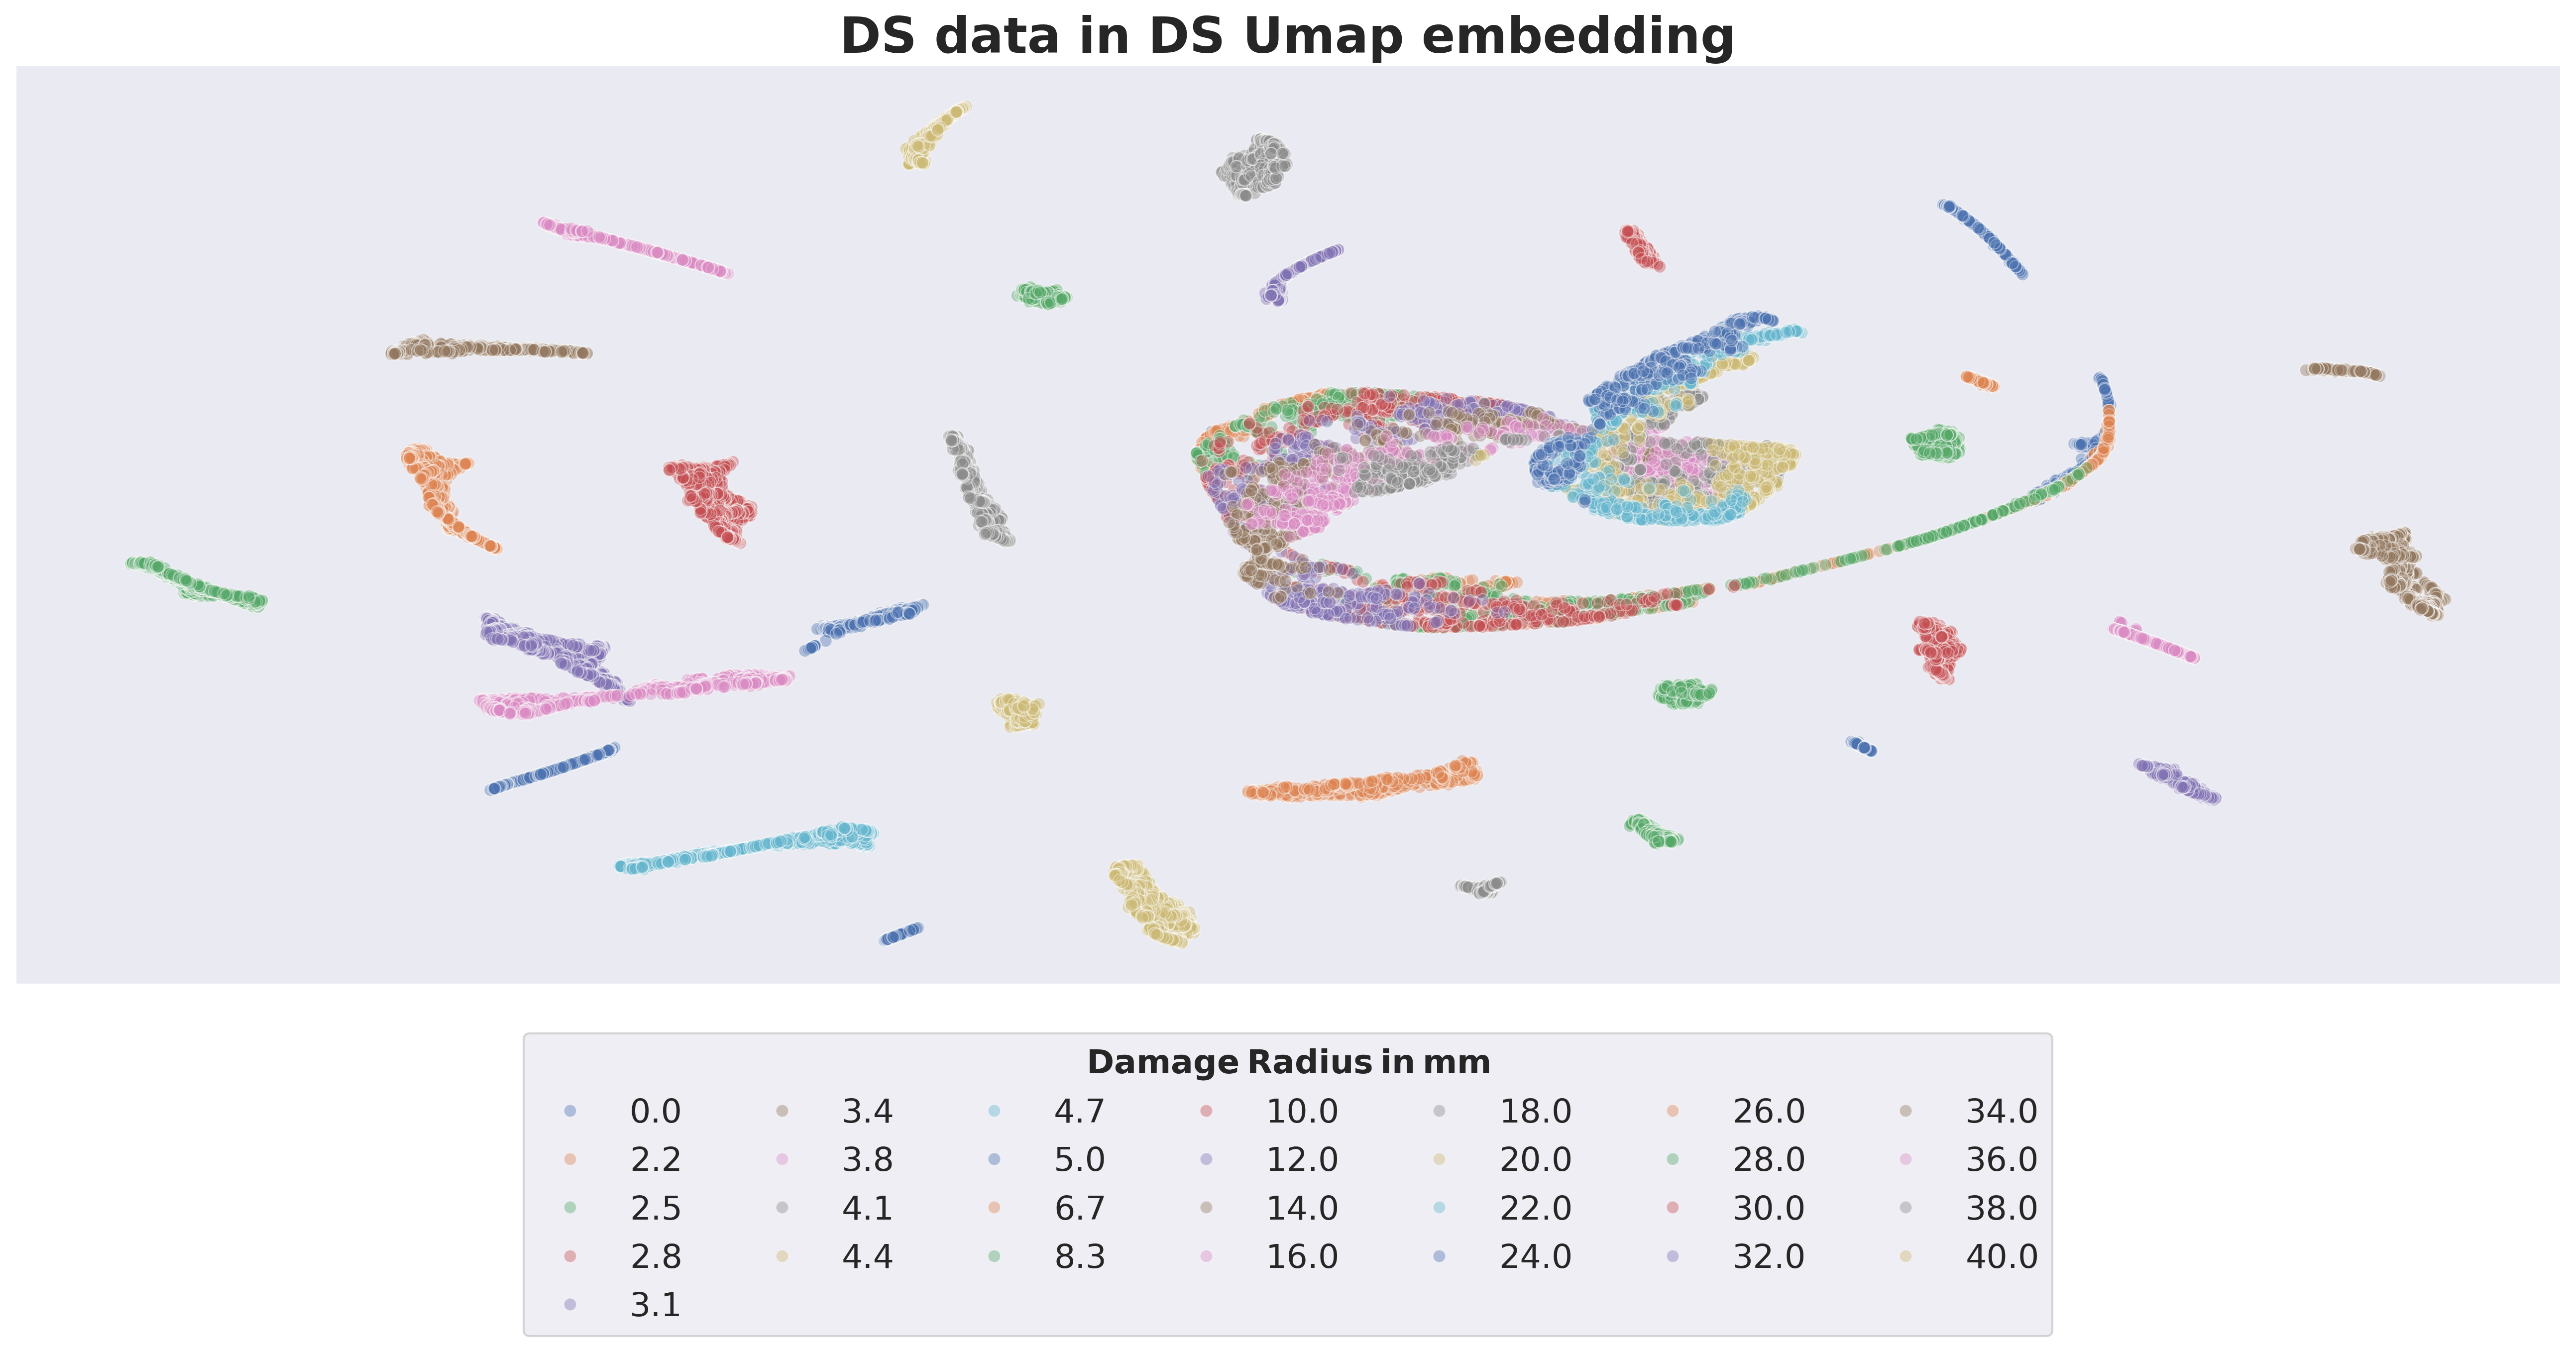

In [14]:
palette = dict(zip(np.unique(y), sns.color_palette(None, len(np.unique(y)))))
fig = plot_embedding_targets(X_embedded, y=y, alpha=0.4, palette=palette)

legend = plt.legend(
    ncol=7,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.4),
    title_fontsize=16,
    fontsize=16,
)
legend.set_title("$\\bf{Damage\:Radius\:in\:mm}$")

plt.title("DS data in DS Umap embedding")
plt.xticks([])
plt.yticks([]);

In [15]:
palette = dict(zip(y, sns.color_palette(None, len(y))))


def interactive_plot(low=0.0, high=40.0):
    y_input = enc.inverse_transform(y_resampled.reshape(-1, 1)).flatten()
    fltr = (y_input >= low) & (y_input <= high)

    x_input = umap.transform(X_resampled[fltr])
    y_input = y_input[fltr]
    fig = plot_embedding_targets(x_input, y=y_input, alpha=0.9, palette=palette)

    legend = plt.legend(
        ncol=7,
        loc="lower center",
        bbox_to_anchor=(0.5, -0.4),
        title_fontsize=16,
        fontsize=16,
    )
    legend.set_title("$\\bf{Damage\:Radius\:in\:mm}$")

    plt.title("ClusterCentroid sampled data in DS Umap embedding")
    plt.xticks([])
    plt.yticks([])


widgets.interact(interactive_plot, low=np.unique(y), high=np.unique(y));

interactive(children=(Dropdown(description='low', options=(0.0, 2.2, 2.5, 2.8, 3.1, 3.4, 3.8, 4.1, 4.4, 4.7, 5…

In [16]:
def plot_feature(feature=0):
    fig = sns.lineplot(
        x=range(X.shape[0]), y=X[y.argsort(), feature], hue=y[y.argsort()], legend=None
    )
    fig.set_title("Feature over samples ordered by 'y_radius'")
    plt.gca().set_xlabel("Samples sorted by 'y_radius'")
    plt.gca().set_ylabel(f"Feature: {feature}")


widgets.interact(plot_feature, feature=(0, X.shape[-1] - 1, 1));

interactive(children=(IntSlider(value=0, description='feature', max=30), Output()), _dom_classes=('widget-inte…

In [17]:
from pipe_utils import build_sampled_pipeline
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from imblearn.under_sampling import ClusterCentroids

samples_per_class = 40
n_classes = len(np.unique(y))
strgy = dict(zip(range(n_classes), [samples_per_class] * n_classes))
sampler = ClusterCentroids(
    estimator=KMeans(n_init="auto", random_state=random_state),
    sampling_strategy=strgy,
    random_state=random_state,
)

estimator = KNeighborsRegressor(n_neighbors=1, leaf_size=1)

pipeline = build_sampled_pipeline(sampler, estimator)

In [18]:
scoring = get_synth_regression_scoring()

results = conduct_aa_reg_experiment(
    X=X,
    y=y,
    estimator=pipeline,
    name="BASE",
    n_repeats=5,
    n_splits=32,
    test_size=0.1,
    scoring=scoring,
    random_state=random_state,
)

## Store results for later

In [19]:
results.to_pickle(result_file)

## Plot some results for overview

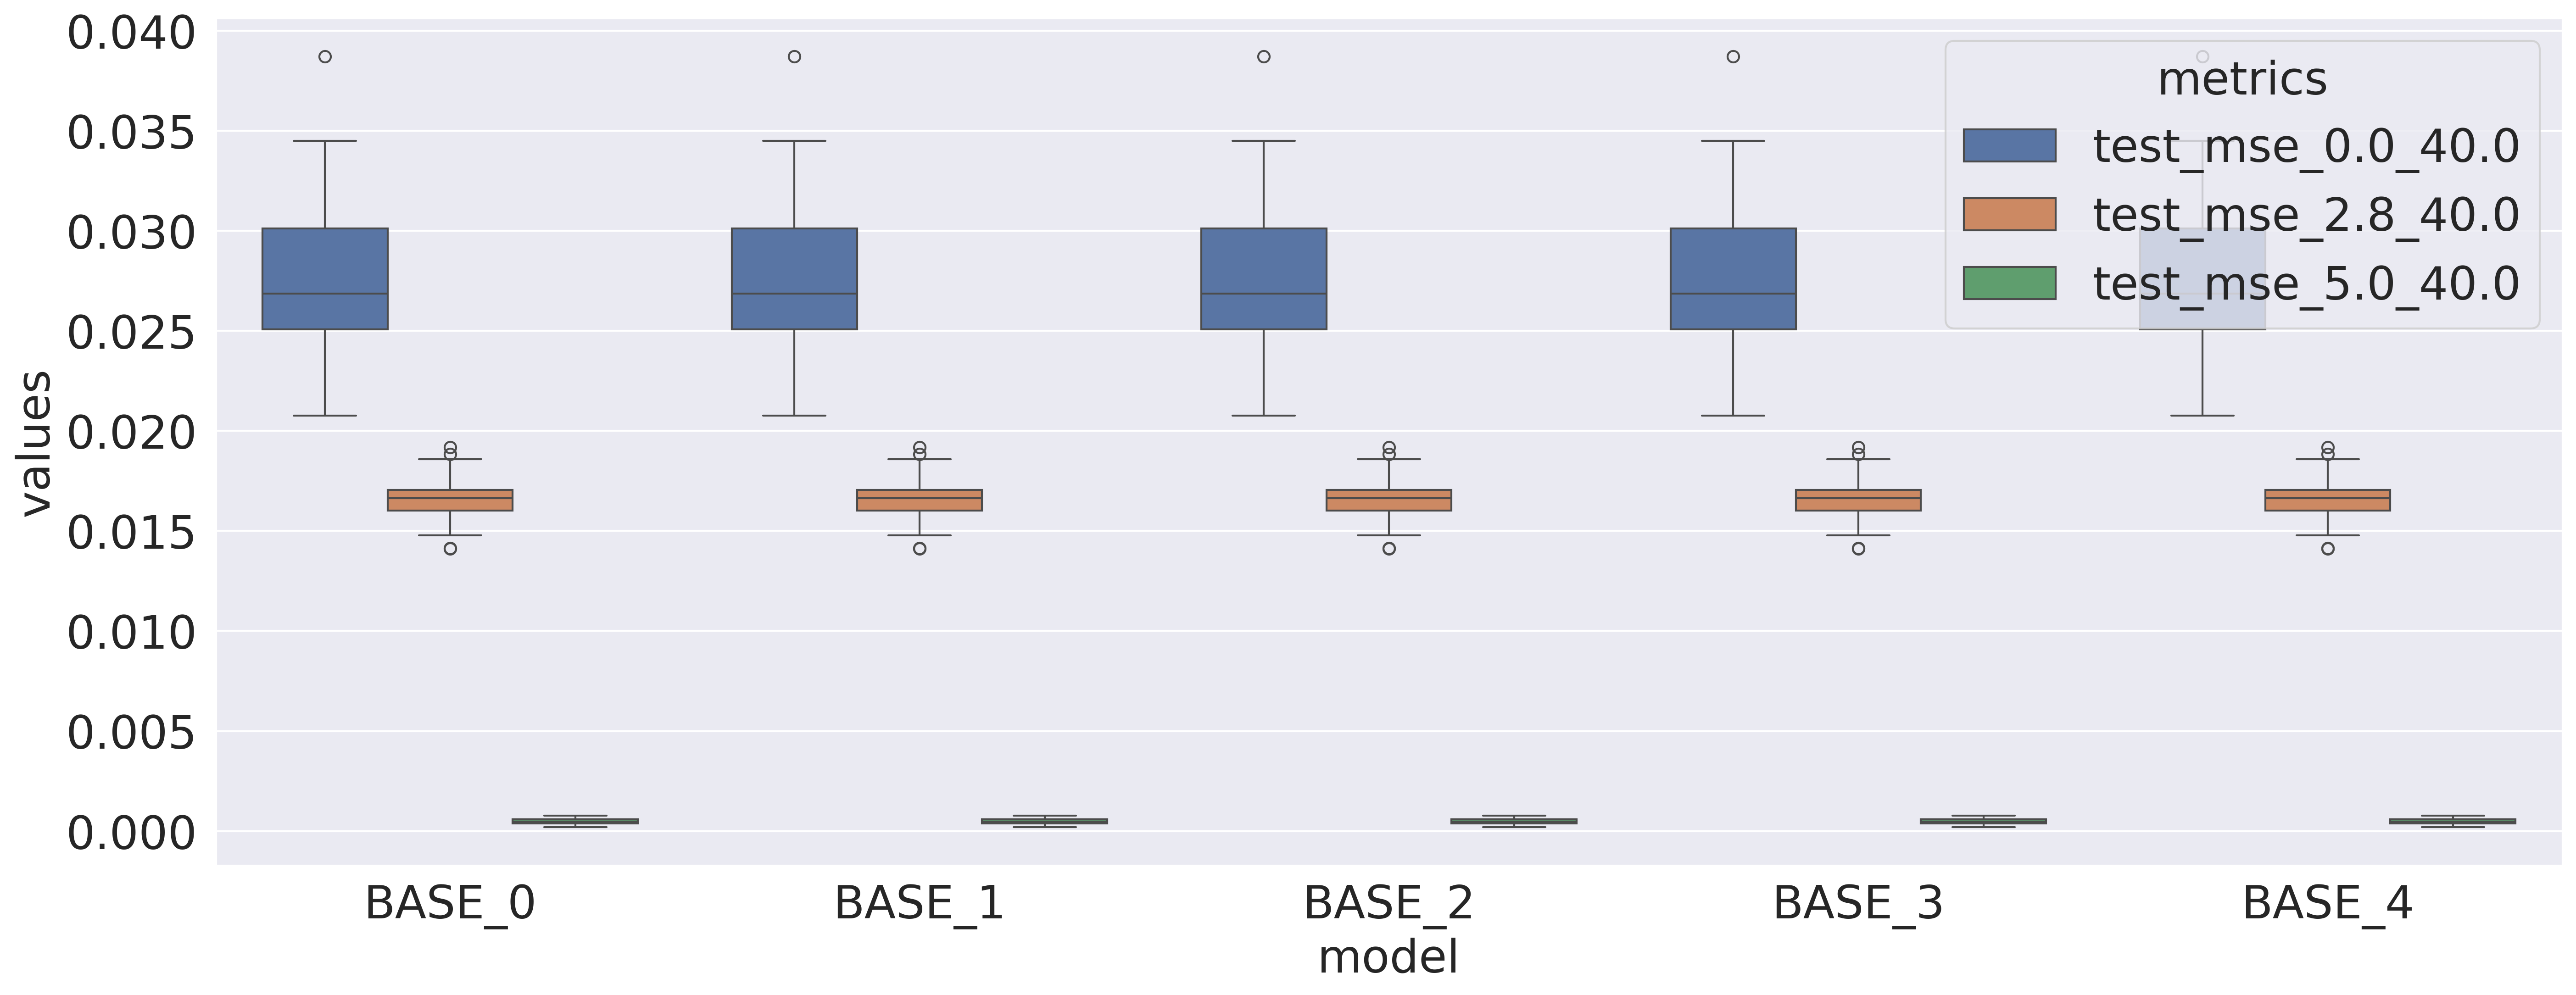

In [20]:
fig = plot_metrics(
    extract_metrics(
        results, ["test_mse_0.0_40.0", "test_mse_2.8_40.0", "test_mse_5.0_40.0"]
    )
)
plt.show()

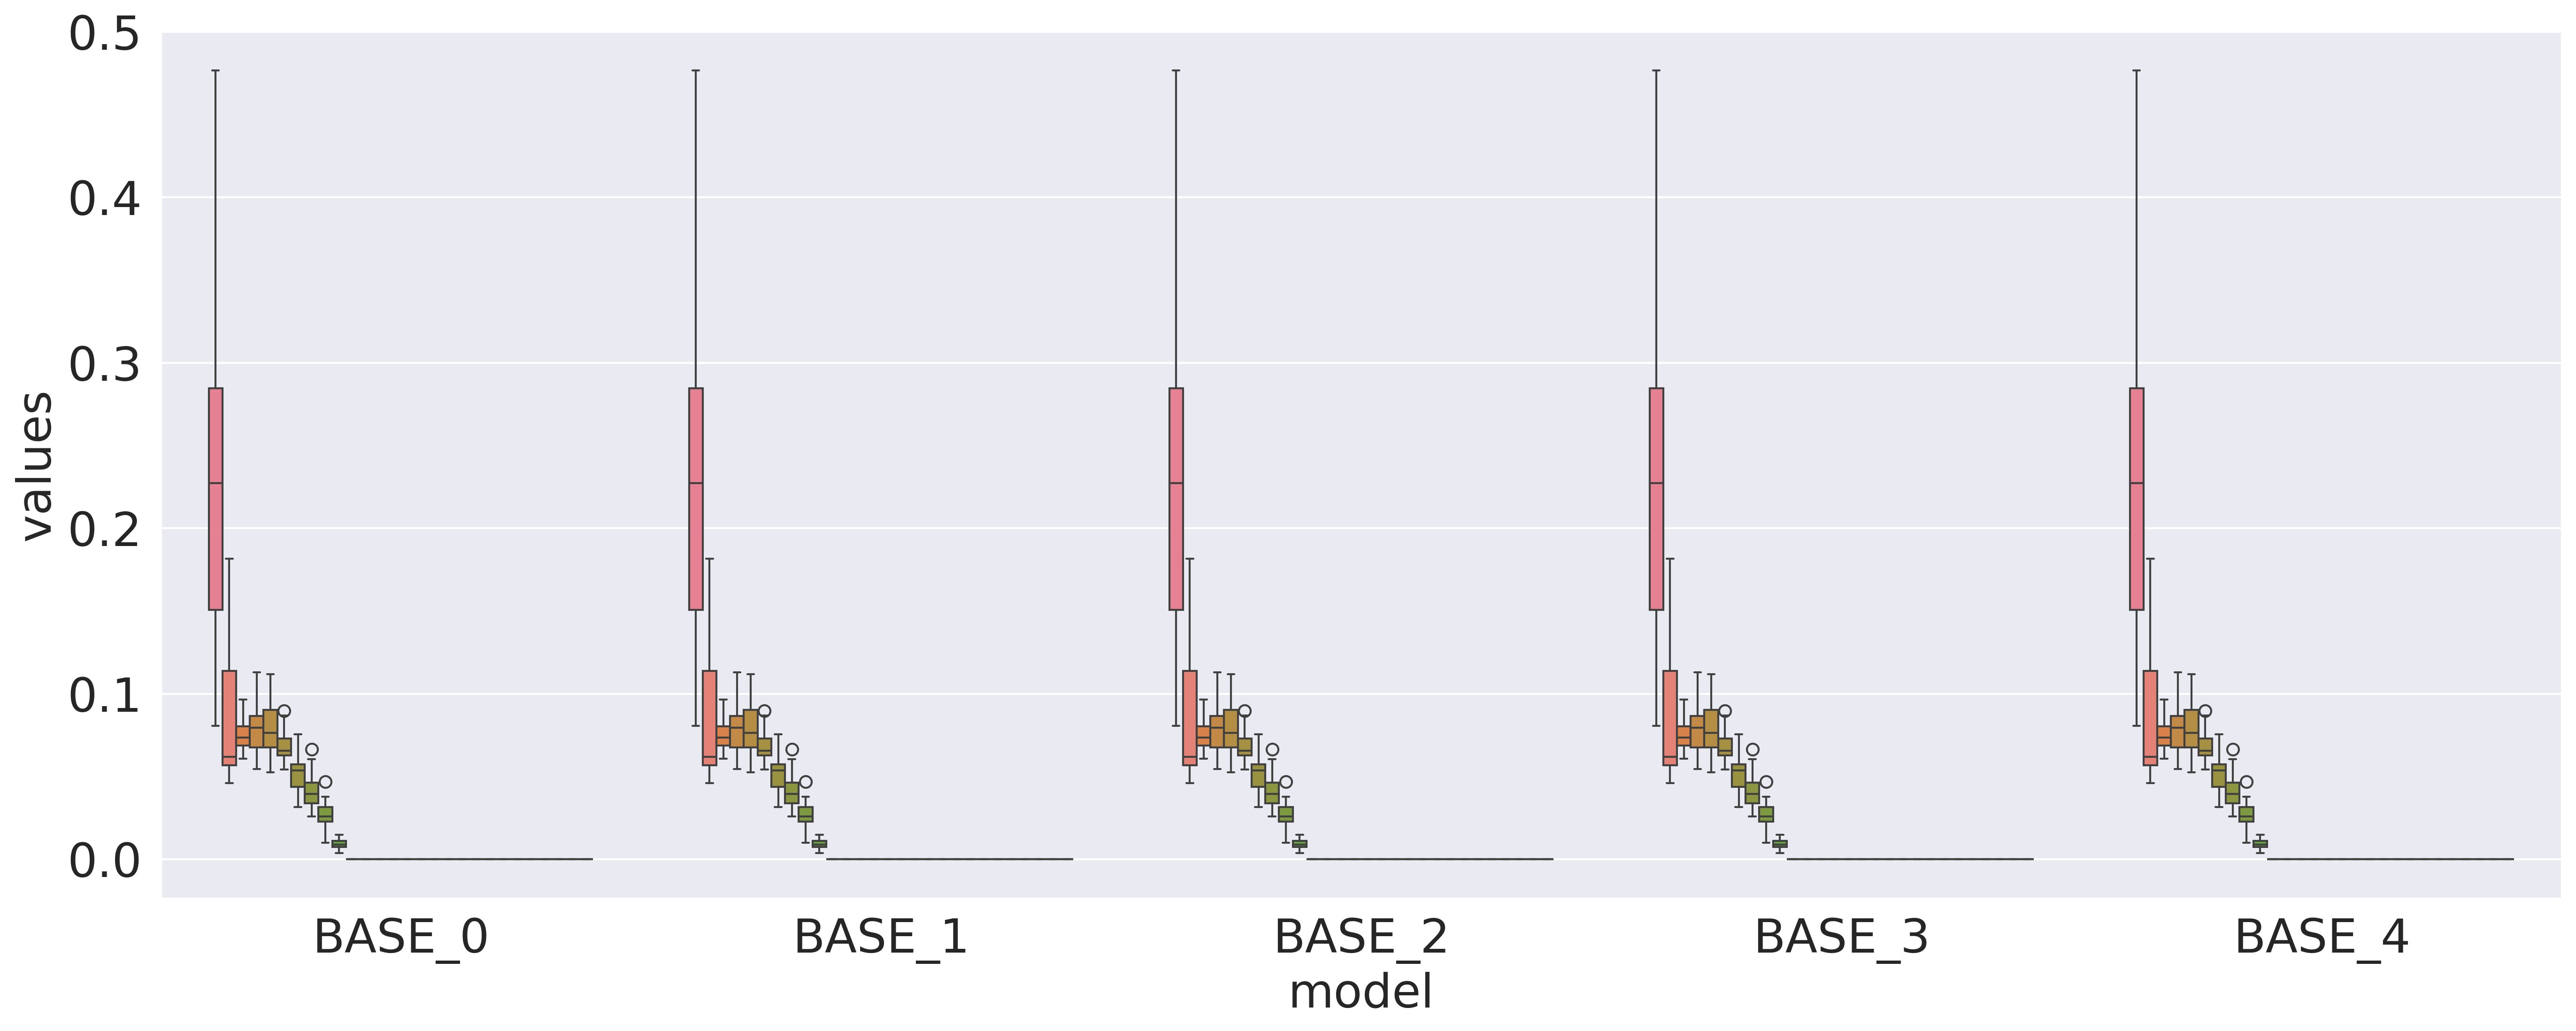

In [21]:
shm_scoring = SHM_Scoring()

fig = plot_metrics(extract_metrics(results, shm_scoring.SYNTH_MSE_RESULTS))
plt.gca().get_legend().remove()

plt.show()